In [25]:
import numpy as np # Linear algebra
import pandas as pd  # DataFrames
import seaborn as sns  # Plots
import matplotlib.pyplot as plt  # Plots
import cv2  # Image processing

# Neural networks
import tensorflow as tf  # Deep learning
import keras  # Gigh-level API for models
from keras.preprocessing import image  # Load/preprocess images
from keras.models import Sequential  # Ñinear model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization  # CNN layers
from tensorflow.keras import layers, models  # Alternative layer/model tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image loading + augmentation
from keras import regularizers  # Avoid overfitting
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax # Optimizers
from tensorflow.keras.models import load_model  # load saved models
from tensorflow.keras.callbacks import EarlyStopping # Import an early stopping

import zipfile  # Unzip files
import os  # File/folder operations
import pickle 

## **Download database**

<div align = "justify">

The database is obtained from a Kaggle repository called 'Brain Tumor MRI Dataset' and unzip in order to work with it

[Kaggle tumor dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

</div>

In [3]:
# ZIP path file 
zip_path = r"\Users\diego\OneDrive\Documentos\Materias UDLAP\Python\Artificial_intelligence\Cancer_detection_system\cnn\archive.zip"

# Folder where the files will be extracted
extract_path = r"\Users\diego\OneDrive\Documentos\Materias UDLAP\Python\Artificial_intelligence\Cancer_detection_system\cnn"

# Extract the folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref: # Function that opens a zip file
    zip_ref.extractall(extract_path) # Extract all the files in the specified path

print("Extraction complete")

print("Files: ", os.listdir(path=extract_path))

Extraction complete
Files:  ['archive.zip', 'CNN_model.ipynb', 'Testing', 'Training', 'version1_cnn.h5', 'version1_history_cnn.pkl']


In [26]:
# Path to both folders 
train_folder = r"\Users\diego\OneDrive\Documentos\Materias UDLAP\Python\Artificial_intelligence\Cancer_detection_system\cnn\Training"
test_folder = r"\Users\diego\OneDrive\Documentos\Materias UDLAP\Python\Artificial_intelligence\Cancer_detection_system\cnn\Testing"

In [27]:
img_size = 224 # Set the image size (we can also try with 256) 
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    image_size = (img_size, img_size), # Resize every image
    labels = 'inferred',
    batch_size = 32, # Just load 32 images. In each iteration the NN will just process 32 images, that helps the RAM
    shuffle = True # Shuffle the data
)

Found 5712 files belonging to 4 classes.


In [28]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, # Path where tensorflow will obtain the images 
    image_size = (img_size, img_size), # Resize ever image 
    labels = 'inferred', # Labels are generated from the directory structure
    batch_size = 32 # Just load 32 images in each iteration
)

Found 1311 files belonging to 4 classes.


In [29]:
# Check classes 
classes_names = train_dataset.class_names
print("Classes: ", classes_names)

Classes:  ['glioma', 'meningioma', 'notumor', 'pituitary']


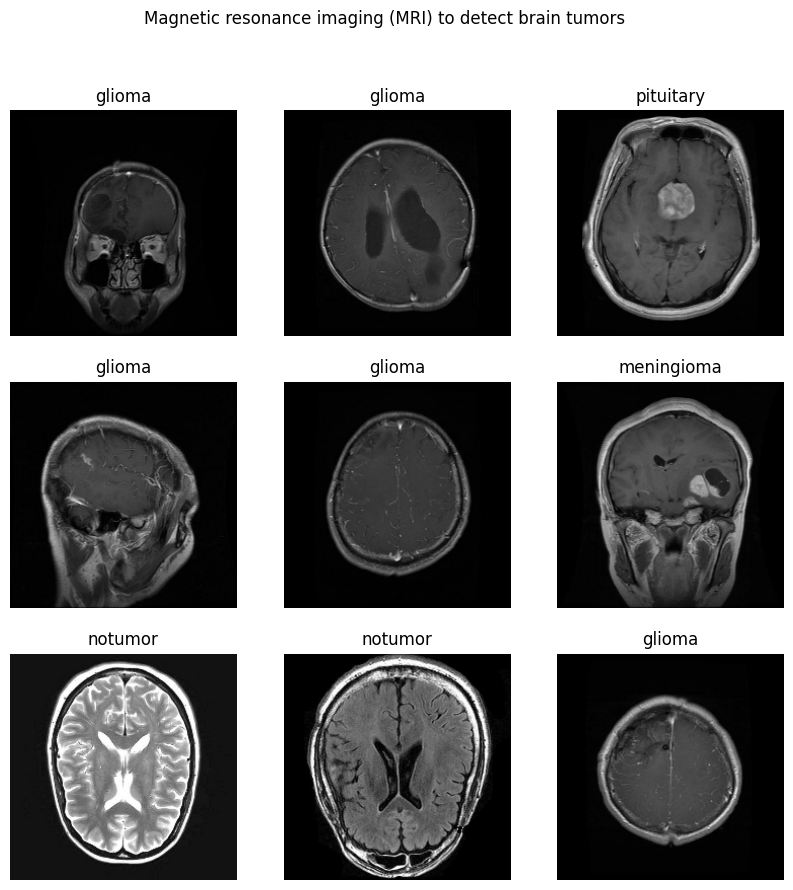

In [30]:
# Plot some images
for images, labels in train_dataset.take(1): # Take the first batch

    plt.figure(figsize=(10, 10)) # Chnage the size of the figure
    plt.suptitle("Magnetic resonance imaging (MRI) to detect brain tumors") # General title

    for i in range(9): # Number of images that will be shown
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #print(labels[i].numpy()) # This returns a tensorflow array and then it converts it into a numpy array (easier to use)
        plt.title(classes_names[labels[i].numpy()])  # Show the class name
        plt.axis("off") # Desactivate axis


### Create Convolutional Neuronal Network (CNN)

In [31]:
# Define the ImageDataGenerator with data augmentation and validation split
train_data_aug = ImageDataGenerator(
    rotation_range=180,  # Randomly rotate the image by up to 180 degrees
    width_shift_range=0.2,  # Randomly shift the image horizontally by up to 20% of the total width
    height_shift_range=0.2,  # Randomly shift the image vertically by up to 20% of the total height
    horizontal_flip=True,  # Randomly flip the image horizontally
    rescale=1./255,  # Normalize the pixel values to the range [0, 1]
    zoom_range=0.3,  # Zoom in or zoom out by 20%
    brightness_range=(0, 0.7) , # Randomly adjust brightness
    validation_split=0.2  # Reserve 20% of data for validation
)

# Apply data augmentation to the training data
train_generated_data = train_data_aug.flow_from_directory(
    train_folder,  # Directory with training images
    target_size=(img_size, img_size),  # Resize images to the target size
    batch_size=32,  # Number of images per batch
    color_mode='grayscale',  # Convert images to grayscale
    class_mode='categorical',  # Since we have multiple categories
    subset='training',  # Use the training subset (80%)
    shuffle=True  # Shuffle the training data
)

# Apply data augmentation to the validation data
validation_generated_data = train_data_aug.flow_from_directory(
    train_folder,  # Directory with training images
    target_size=(img_size, img_size),  # Resize images to the target size
    batch_size=32,  # Number of images per batch
    color_mode='grayscale', # Convert images to grayscale
    class_mode='categorical', # Since we have multiple categories
    subset='validation', # Use the validation subset (20%)
    shuffle=False # Validation data should not be shuffled
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


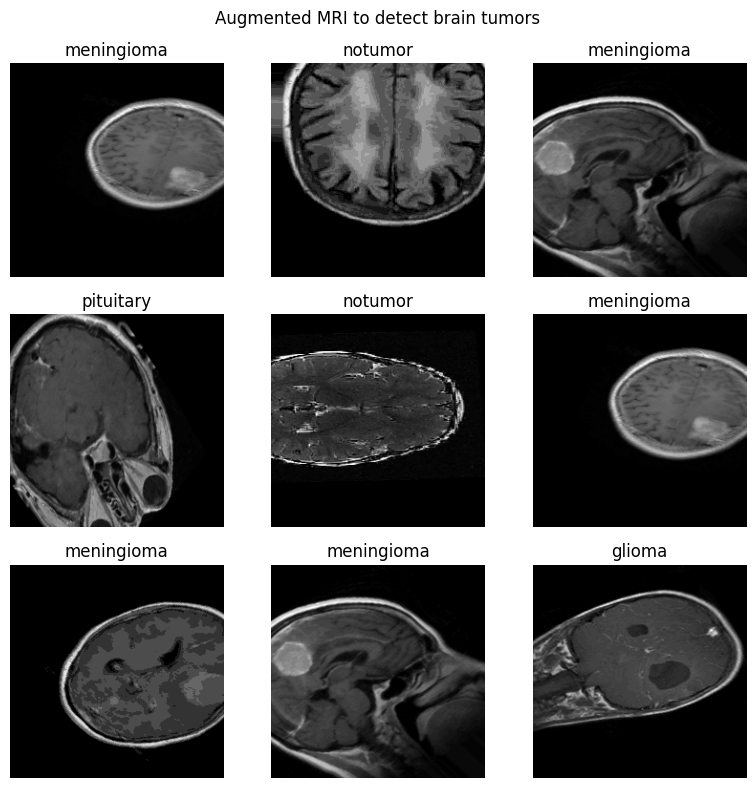

In [43]:
### Print some images to visualize the generated train dataset

# Take the first batch from the generator
first_batch = next(iter(train_generated_data))

# Extract images and labels from the batch
first_images, first_labels = first_batch

# Create a dictionary with the images
dict_aumented_images = {'first_images': first_images, 'first_labels': first_labels}

# Create figure to plot the images
fig, ax = plt.subplots( # Create figure
    figsize=(8, 8), nrows=3, ncols=3
)
plt.suptitle("Augmented MRI to detect brain tumors") # General title

axes = ax.flatten() # Flatten the array

for i in range(9): # Number of images that will be shown
    random_num = int(np.random.randint(20)) # Create random numbers 
    axes[i].imshow(first_images[random_num], cmap='gray')

    # Look for the class name, it is an array like this form [0, 0, 1, 0]
    name_idx = 0
    for idx, val in enumerate(first_labels[random_num]):
        if val == 1.0:
            name_idx = idx

    axes[i].set_title(f'{classes_names[name_idx]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### **Train the CNN**

In [34]:
# Include an early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor this variable
    patience=3,  # Number of epochs without enhancing the model
    restore_best_weights=True # Restore the best weights
)

### Create Convolutional Neuronal Network (CNN)

In [10]:
model = tf.keras.Sequential([

    # Bloque 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(225, 225, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    # Bloque 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    # Bloque 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.4),

    # Bloque 4 (nuevo)
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.5),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    # Capa de salida
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 225, 225, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 225, 225, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 225, 225, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 225, 225, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,934,372 (102.75 MB)

 Trainable params: 26,931,428 (102.74 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
# Train the CNN
history = model.fit(train_generated_data, 
                    epochs=30,
                    validation_data=validation_generated_data,
                    )

# # Train the CNN
# history = model.fit(train_generated_data, epochs=30, 
#                     validation_data=validation_generated_data,  # Validation dataset
#                     callbacks=[early_stopping] # Include an early stopping
#                     )

# Inmediately save the model
model.save('version5_cnn.h5')  # Save the entire model to use it later
# model.save_weights('model_weights.weights.h5')  # Save weights in HDF5 format with the correct extension

# Save the training history to a file (this helps to reuse and visualize training metrics)
with open('version5_history_cnn.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.3628 - loss: 1.5486 - val_accuracy: 0.2033 - val_loss: 1.5139
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.4358 - loss: 1.2843 - val_accuracy: 0.2340 - val_loss: 1.5534
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.4907 - loss: 1.1317 - val_accuracy: 0.2796 - val_loss: 4.1643
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.5528 - loss: 1.0256 - val_accuracy: 0.2796 - val_loss: 7.6394
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 430s 3s/step - accuracy: 0.5853 - loss: 0.9756 - val_accuracy: 0.2805 - val_loss: 5.0450
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - accuracy: 0.6098 - loss: 0.9025 - val_accuracy: 0.5110 - val_loss: 1.1327
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.6223 - loss: 0.8815 - val_accuracy: 0.5197 - val_loss: 1.1543
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.6263 - loss: 0.8846 - val_accu

In [37]:
# Continue training
tf.config.run_functions_eagerly(True)
# Load the previous model
model = load_model('version4_cnn.h5')

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training for 10 more epochs
history2 = model.fit(
    train_generated_data,
    epochs=5,
    validation_data=validation_generated_data
)

# Load the previous history
with open('version4_history_cnn.pkl', 'rb') as f:
    old_history = pickle.load(f)

# Merge history
for key in history2.history:
    old_history[key] += list(history2.history[key])  # Convert to list before adding


# Save the combined history again
with open('version4_history_continued_cnn.pkl', 'wb') as f:
    pickle.dump(old_history, f)

# Save the updated model
model.save('version4_continued_cnn.h5')

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - accuracy: 0.7707 - loss: 0.5934 - val_accuracy: 0.2954 - val_loss: 3.5801
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 585s 4s/step - accuracy: 0.7769 - loss: 0.5723 - val_accuracy: 0.5460 - val_loss: 1.1902
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 533s 4s/step - accuracy: 0.8051 - loss: 0.5232 - val_accuracy: 0.5101 - val_loss: 1.4835
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 532s 4s/step - accuracy: 0.8165 - loss: 0.4738 - val_accuracy: 0.6521 - val_loss: 1.1791
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 536s 4s/step - accuracy: 0.8290 - loss: 0.4769 - val_accuracy: 0.5530 - val_loss: 1.5627


#### AlexNET


[Kaggle AlexNet](https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner)

In [105]:
alexNet_model = keras.Sequential([
    # Primera capa convolucional (adaptada a 1 canal para imágenes en escala de grises)
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_size, img_size, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    # Segunda capa convolucional
    layers.Conv2D(filters=256, kernel_size=(5,5), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    # Tercera, cuarta y quinta capas convolucionales
    layers.Conv2D(filters=384, kernel_size=(3,3), padding="same", activation='relu'),
    layers.Conv2D(filters=384, kernel_size=(3,3), padding="same", activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),

    # Flatten + Fully Connected Layers
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),

    # Capa de salida con 4 clases
    layers.Dense(4, activation='softmax')
])

# Compilar el modelo
alexNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
alexNet_model.summary()

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 54, 54, 96)     │        11,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 54, 54, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     6,554,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,333,700 (43.23 MB)

 Trainable params: 11,332,996 (43.23 MB)

 Non-trainable params: 704 (2.75 KB)

In [123]:
# Train the AlexNet CNN
alexNet_history = alexNet_model.fit(train_generated_data, 
                                    epochs=20 
                                    #validation_data=validation_generated_data, # Validation dataset
                                    )

# Inmediately save the model
alexNet_model.save('alexNet_version3_cnn.h5')  # Save the entire model to use it later
# model.save_weights('model_weights.weights.h5')  # Save weights in HDF5 format with the correct extension

# Save the training history to a file (this helps to reuse and visualize training metrics)
with open('alexNet_version3_history_cnn.pkl', 'wb') as f:
    pickle.dump(alexNet_history.history, f)

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 514ms/step - accuracy: 0.2751 - loss: 1.3852
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 530ms/step - accuracy: 0.2693 - loss: 1.3846
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 527ms/step - accuracy: 0.2853 - loss: 1.3832
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 520ms/step - accuracy: 0.2763 - loss: 1.3845
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 509ms/step - accuracy: 0.2918 - loss: 1.3820
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.2728 - loss: 1.3846
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 506ms/step - accuracy: 0.2879 - loss: 1.3820
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 503ms/step - accuracy: 0.2820 - loss: 1.3838
Epoch 9/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.2762 - loss: 1.3847
Epoch 10/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 504ms/step - accuracy: 0.2792 - loss: 1.3835
Epoch 11/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 505ms/step - accuracy: 0.2806 - loss: 1.3834
Epoch 12/20
179/179

### Plot the performance of the model

In [12]:
# Load a trained model and its training history from specified files and plot training and validation accuracy and loss
def plot_training_history(history_file):
    """
    Parameter:
    model_file: Path to the trained model file ('version1_cnn.h5').
    history_file: Path to the file containing the training history ('version1_history_cnn.pkl').
    """
    
    # Load the training history from the .pkl file
    with open(history_file, 'rb') as f:
        history = pickle.load(f)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.get('accuracy', []), label='Training accuracy')
    plt.plot(history.get('val_accuracy', []), label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model accuracy', fontweight='bold')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.get('loss', []), label='Training loss')
    plt.plot(history.get('val_loss', []), label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model loss', fontweight='bold')
    plt.legend()

    plt.tight_layout()
    plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


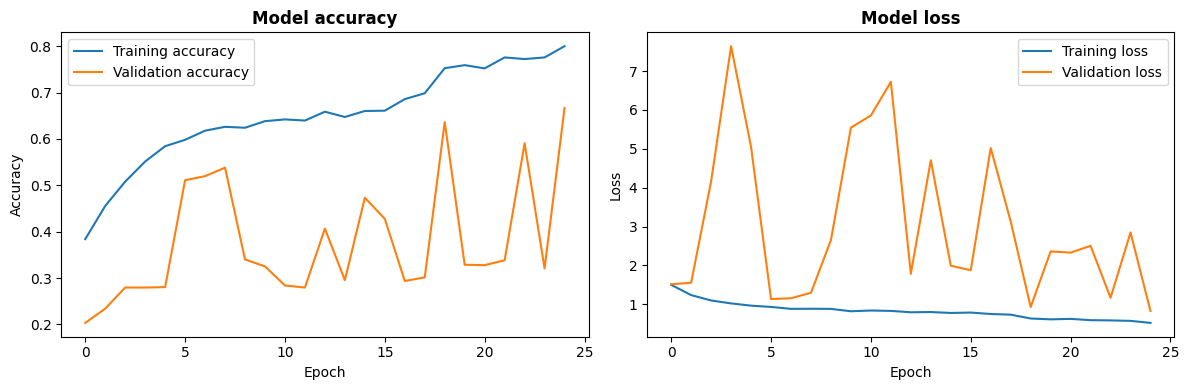

In [50]:
# Check if the model is alright
with open('version4_history_cnn.pkl', 'rb') as f:
        history_v1_cnn = pickle.load(f)
print(history_v1_cnn.keys())

# Call the function to plot the metrics
plot_training_history('version4_history_cnn.pkl')

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


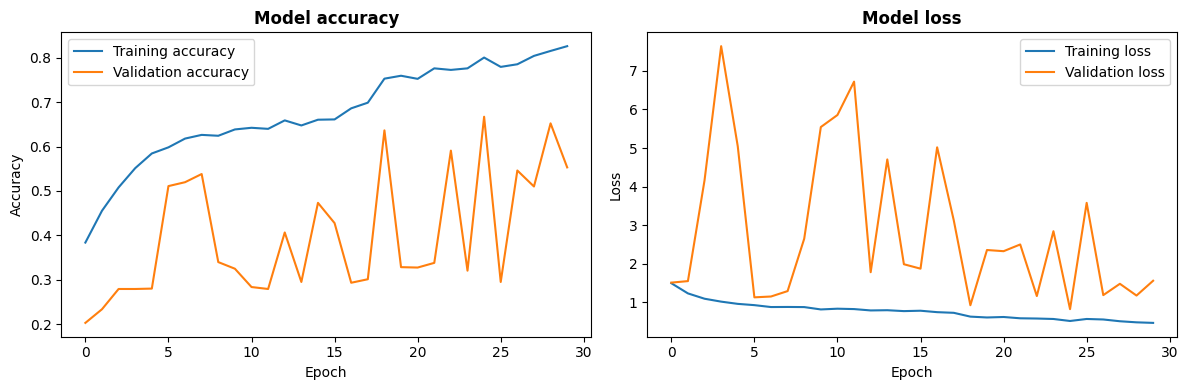

In [51]:
# Check if the model is alright
with open('version4_history_cnn.pkl', 'rb') as f:
        history_v1_cnn = pickle.load(f)
print(history_v1_cnn.keys()) # Print the keys of the dictionary

# Call the function to plot the model history
plot_training_history('version4_history_continued_cnn.pkl')